In [1]:
from ucimlrepo import fetch_ucirepo
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
#Setting any constant values
SIG = 0.05

In [3]:
#N -> Nominal Data
#O -> Ordinal Data
#D -> Discrete Data
#C -> Continous Data
data_type = {"age":"C" 
            ,"sex":"N" #Binomial
            ,"cp": "N"
            ,"trestbps": "C"
            ,"chol": "C"
            ,"fbs": "N"
            ,"restecg": "N"
            ,"thalach": "C"
            ,"exang": "N" #Binomial
            ,"oldpeak": "C"
            ,"slope": "N"
            ,"ca":"D"
            ,"thal": "N"
            ,"diagnosis":"N"}

In [4]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets
y = y.rename(columns={"num":"diagnosis"})

data = X.join(y)

In [5]:
#Checks calculated p-value for significance
def pass_sig (p_val):
    if p_val < SIG:
        return 1

    return 0

In [6]:
#Checks data types to help determine what test to use to check for correlation
def type_comparison(a, b):
    comp = -1
    comp = 0 if a == b == "N" else comp
    comp = 1 if a == b == "C" else comp
    comp = 1 if a == b == "D" else comp

    comp = 2 if (a == "N" and b == "C") or (a == "C" and b == "N") else comp
    comp = 2 if (a == "N" and b == "D") or (a == "D" and b == "N") else comp
    comp = 1 if (a == "D" and b == "C") or (a == "C" and b == "D") else comp

    return comp

In [7]:
#Uses the chi-squared test to check for significance between nominal features
def nominal_corr(a, b):
    chi_square_args = pd.crosstab(a, b)

    _, p, _, _ = stats.chi2_contingency(chi_square_args)
    

    return pass_sig(p)

In [8]:
#Uses the pearson test to check for significance between numeric features.
def numeric_corr(a, b) : return a.corr(b, 'pearson')

In [9]:
#Uses the Kruskal-Wallis test to check for correlation between nominal and numeric features
#Function is set up to assume that a contains the nominal features
def nom_num_corr(a,b):
    
    #Checks how many categories there are
    categories = a.unique().tolist()
    categories = [x for x in categories if str(x) != 'nan']        

    #Creates a single dataframe out of a and b
    data = {"a":a, "b":b}
    df = pd.concat(data, axis = 1)
    df = df.sort_values(by='a')
    df.set_index(keys=['a'], drop=False, inplace=True)

    #Splits the values of b into different lists based on what category of a they match to and performs the Kruskal-Wallis test
    f, p = stats.kruskal(*[list(df.loc[df['a']==i].b.squeeze(axis=0)) for i in categories], nan_policy='omit')

    return pass_sig(p)

In [10]:
num_num_correlation_matrix = []
num_nom_correlation_matrix = []
nom_nom_correlation_matrix = []

#Cycles through all features and tests them against all other features to determine correlation
for i_name, i, in data.items():
    uu_cur_row = []
    uo_cur_row = []
    oo_cur_row = []
    for j_name, j in data.items():
        daty_comp = type_comparison(data_type[i_name], data_type[j_name])

        match daty_comp:
            case 0:
                oo_cur_row.append(1) if i_name == j_name else oo_cur_row.append(nominal_corr(i, j))
                uo_cur_row.append(np.nan)
                uu_cur_row.append(np.nan)
            case 1:
                uu_cur_row.append(1) if i_name == j_name else uu_cur_row.append(numeric_corr(i, j))
                uo_cur_row.append(np.nan)
                oo_cur_row.append(np.nan)

            case 2:
                result = nom_num_corr(i, j) if data_type[i_name] == "N" else nom_num_corr(j, i)
                result = round(result, 2)
                uo_cur_row.append(1) if i_name == j_name else uo_cur_row.append(result)
                uu_cur_row.append(np.nan)
                oo_cur_row.append(np.nan)


    uu_cur_row = [round(elem, 2) for elem in uu_cur_row]
    oo_cur_row = [round(elem, 2) for elem in oo_cur_row]

    num_num_correlation_matrix.append(uu_cur_row)
    num_nom_correlation_matrix.append(uo_cur_row)
    nom_nom_correlation_matrix.append(oo_cur_row)

In [11]:
title_font = {'fontname':"DejaVu Serif", 'size':22}
axis_font = {'fontname':"DejaVu Serif", 'size':12}
annotation_font = {'fontname':"DejaVu Serif", 'size':10}

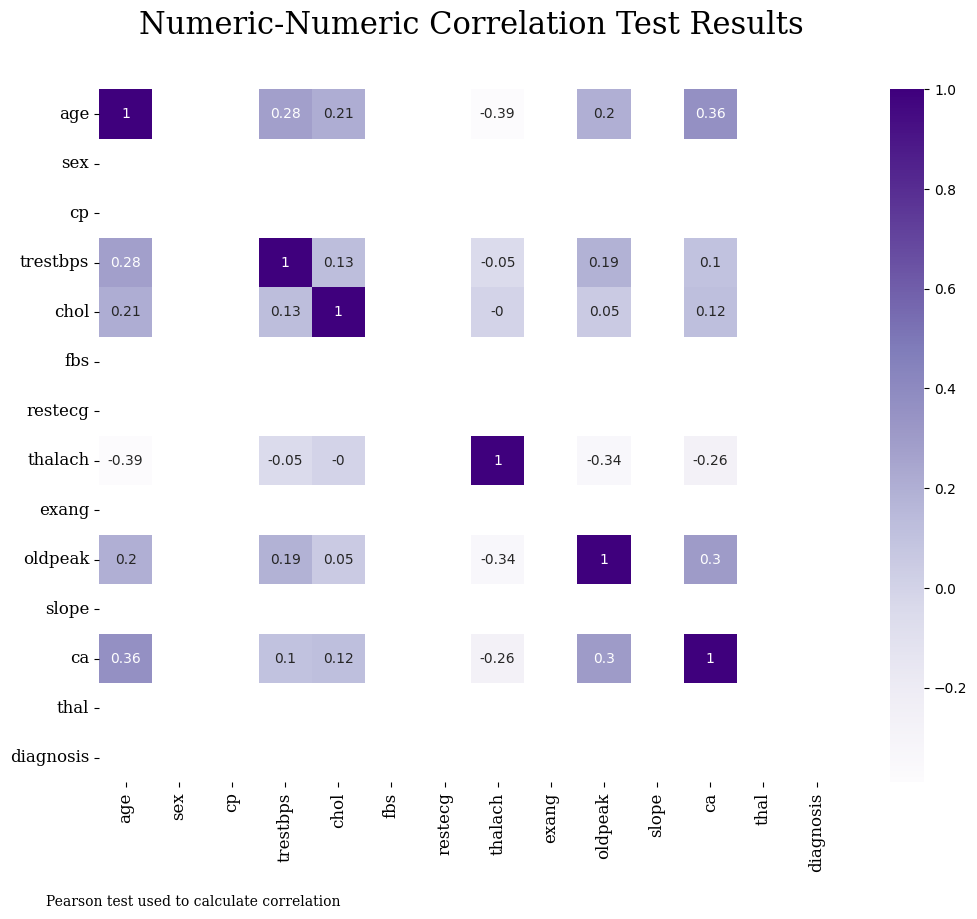

In [12]:
plt.figure(figsize = (12, 9))
plt.title("Numeric-Numeric Correlation Test Results", pad=40, **title_font)
plt.xticks(**axis_font)
plt.yticks(**axis_font)
plt.annotate("Pearson test used to calculate correlation", 
             [-1, 16.5], annotation_clip=False, **annotation_font)
sb.heatmap(num_num_correlation_matrix, cmap="Purples", annot=True, yticklabels=data.columns.tolist(), xticklabels=data.columns.tolist())
plt.savefig("Numeric-Numeric Correlation Test Results.png", bbox_inches='tight')

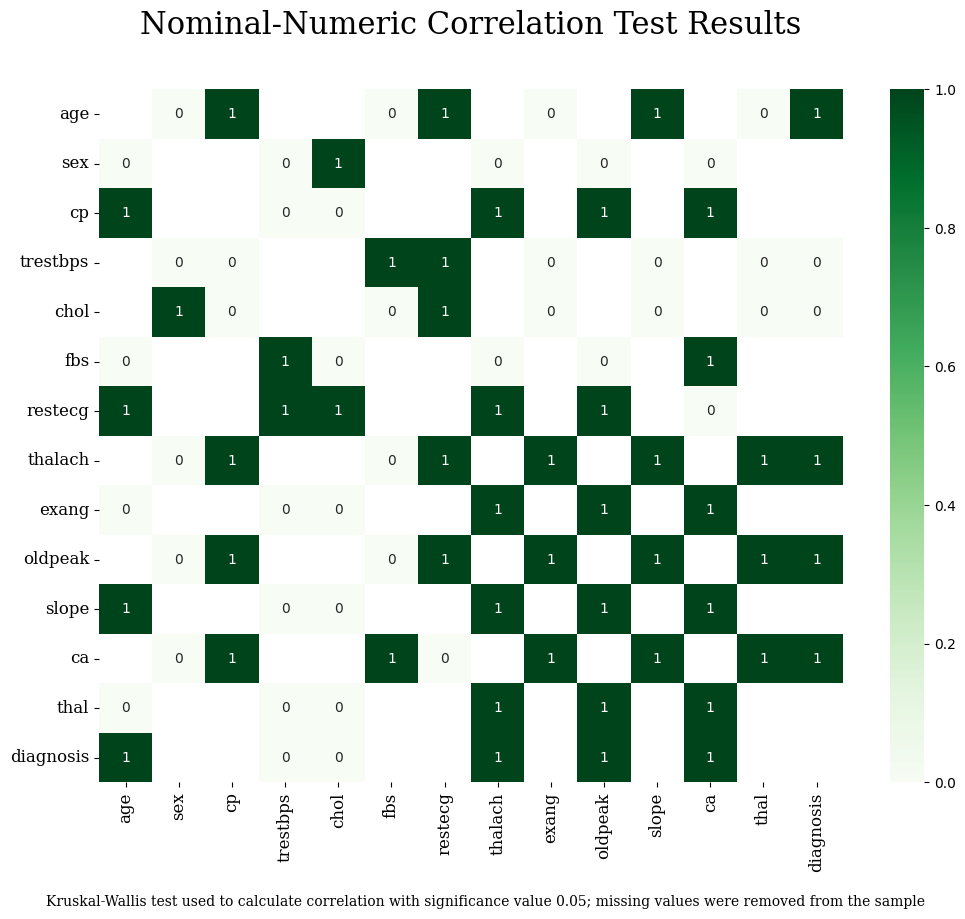

In [13]:
plt.figure(figsize = (12, 9))
plt.title("Nominal-Numeric Correlation Test Results", pad=40, **title_font)
plt.xticks(**axis_font)
plt.yticks(**axis_font)
plt.annotate("Kruskal-Wallis test used to calculate correlation with significance value 0.05; missing values were removed from the sample", 
             [-1, 16.5], annotation_clip=False, **annotation_font)
sb.heatmap(num_nom_correlation_matrix, cmap="Greens", annot=True, yticklabels=data.columns.tolist(), xticklabels=data.columns.tolist())
plt.savefig("Nominal-Numeric Correlation Test Results.png", bbox_inches='tight')

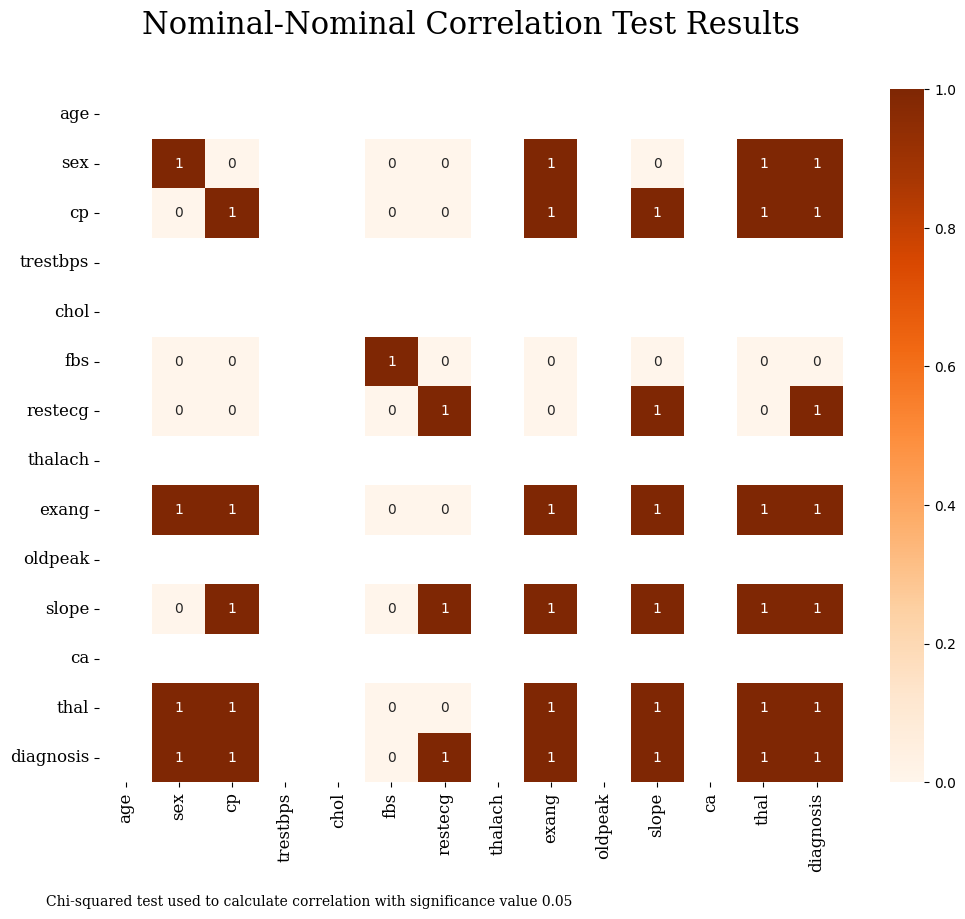

In [14]:
plt.figure(figsize = (12, 9))
plt.title("Nominal-Nominal Correlation Test Results", pad=40, **title_font)
plt.xticks(**axis_font)
plt.yticks(**axis_font)
plt.annotate("Chi-squared test used to calculate correlation with significance value 0.05", 
             [-1, 16.5], annotation_clip=False, **annotation_font)
sb.heatmap(nom_nom_correlation_matrix, cmap="Oranges", annot=True, yticklabels=data.columns.tolist(), xticklabels=data.columns.tolist())
plt.savefig("Nominal-Nominal Correlation Test Results.png", bbox_inches='tight')

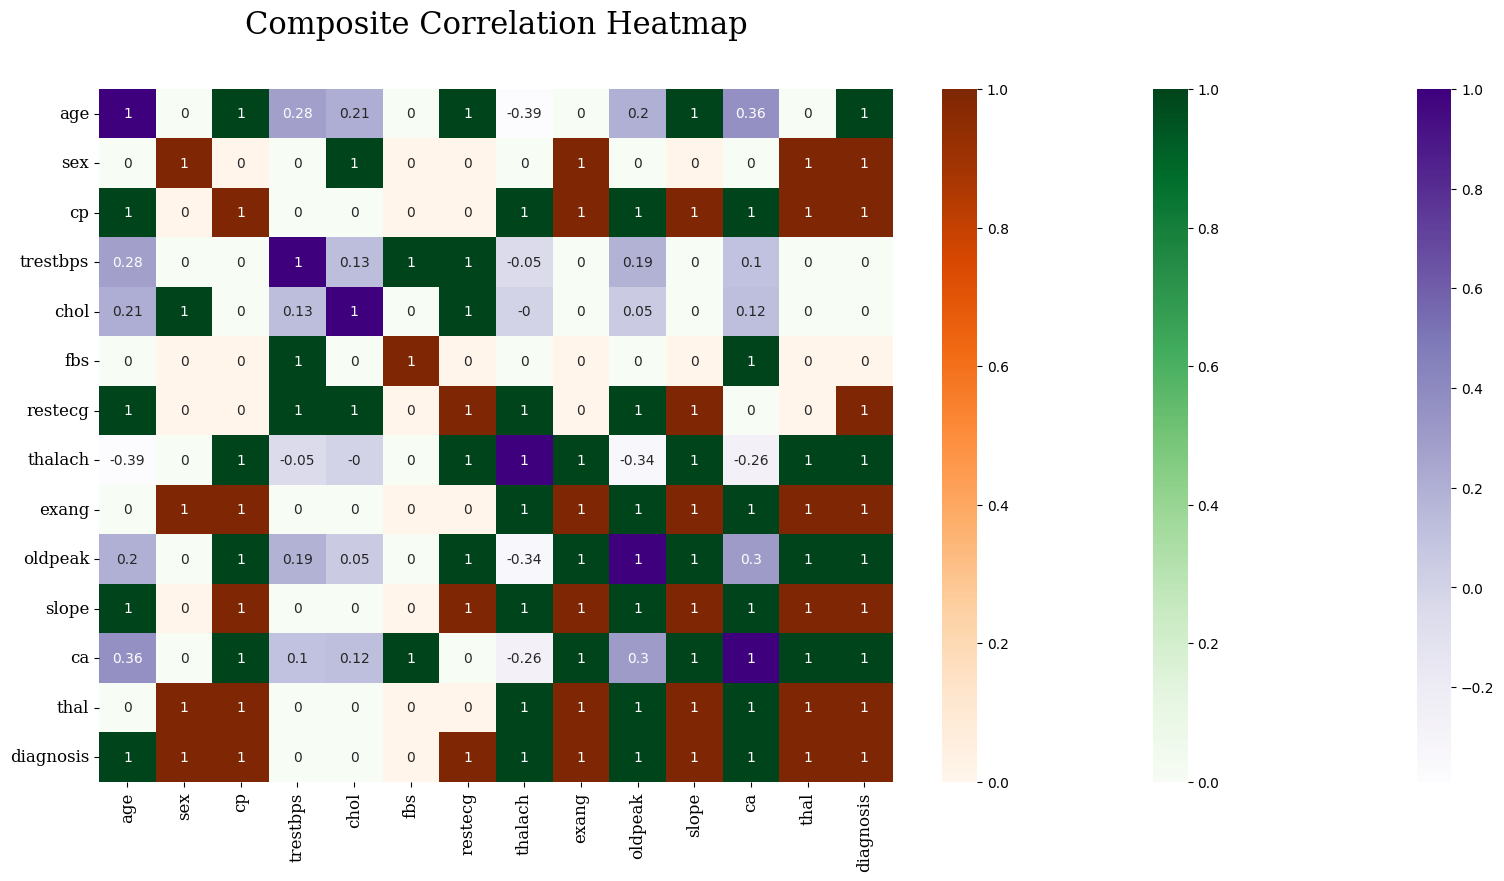

In [15]:
plt.figure(figsize = (20, 9))
plt.title("Composite Correlation Heatmap", pad=40, **title_font)
plt.xticks(**axis_font)
plt.yticks(**axis_font)
sb.heatmap(num_num_correlation_matrix, cmap="Purples", annot=True, yticklabels=data.columns.tolist(), xticklabels=data.columns.tolist())
sb.heatmap(num_nom_correlation_matrix, cmap="Greens", annot=True, yticklabels=data.columns.tolist(), xticklabels=data.columns.tolist())
sb.heatmap(nom_nom_correlation_matrix, cmap="Oranges", annot=True, yticklabels=data.columns.tolist(), xticklabels=data.columns.tolist())
plt.savefig("Composite Correlation Heatmap.png", bbox_inches='tight')